In [1]:
import os
os.chdir("../")

import torch
from torch import nn
import transformers
import datasets
import os
import wandb
from tqdm import tqdm
from contextlib import nullcontext
import safetensors
import json


try:
    from GPT_Trainer.multi_gpu_helpers import is_main_process
    from GPT_Trainer.LlamaDecoderLayer import LlamaDecoderLayer
except ModuleNotFoundError:
    from multi_gpu_helpers import is_main_process
    from LlamaDecoderLayer import LlamaDecoderLayer

/users/gmongaras/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-13 09:03:50.897388: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-13 09:03:51.764445: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Path to the model

# model_path = "models/fineweb_softmax_35bs_2gpu_1024seqlen/"
model_path = "models/fineweb_linear_relu_35bs_2gpu_1024seqlen/"
# model_path = "models/fineweb_linear_elu_35bs_2gpu_1024seqlen/"
# model_path = "models/fineweb_linear_cosine_35bs_2gpu_1024seqlen/"

device = "cuda:0"
model_max_length = 1024


# Read token from .env file
with open(".env", "r") as f:
    token = f.read().strip()

# Tokenizer
try:
    tokenizer = transformers.AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", use_fast=False, cache_dir="GPT_Trainer/llama2", token=token)
    # self.tokenizer = transformers.AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B", use_fast=False, cache_dir="GPT_Trainer/gpt-j-6B")
except OSError:
    raise FileNotFoundError("Token not found in .env file or user does not have access to Llama 2 weights with that token. Please add your Hugging Face token to the .env file.")

tokenizer.pad_token_id = tokenizer.eos_token_id
pad_token = torch.tensor([tokenizer.pad_token_id])
with open(f"{model_path}/config.json", "r") as f:
    attention_type = json.load(f)["attention_type"]

# Set max sequence length
tokenizer.model_max_length = model_max_length

# GPT Model. We are training it from scratch
model = transformers.LlamaForCausalLM(config=transformers.LlamaConfig.from_dict({
    "_name_or_path": "meta-llama/Llama-2-7b-hf",
    "architectures": [
        "LlamaForCausalLM"
    ],
    "bos_token_id": 1,
    "eos_token_id": 2,
    "hidden_act": "silu",
    "hidden_size": 1024, #4096,
    "initializer_range": 0.02,
    "intermediate_size": 1024*2, # 11008
    "max_position_embeddings": model_max_length,
    "model_type": "llama",
    "num_attention_heads": 16,
    "num_hidden_layers": 20,
    "num_key_value_heads": 16,
    "pretraining_tp": 1,
    "rms_norm_eps": 1e-05,
    "rope_scaling": None,
    "tie_word_embeddings": False,
    "torch_dtype": "float16",
    "use_cache": True,
    # "vocab_size": 32000,
    "vocab_size": tokenizer.vocab_size,
    "attention_type": attention_type,
}))


# Replace all self attention layers with the new attention layer
for i, layer in enumerate(model.model.layers):
    old = layer
    model.model.layers[i] = LlamaDecoderLayer(model.config, layer_idx=i, get_taylor_terms=True).to(layer.self_attn.q_proj.weight.device)
    model.model.layers[i].self_attn.layer_num = i
    del old

# Load in params
model.load_state_dict(safetensors.torch.load_file(model_path + "/model.safetensors"), strict=True)
model.eval()


# Clear cache
torch.cuda.empty_cache()

# Number of parameters in billions
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000_000
print(f"Number of parameters: {num_params:.2f}B")
    
model = model.cuda()
model.eval()


Number of parameters: 0.28B


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 1024)
    (layers): ModuleList(
      (0-19): 20 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (abs_pos_enc): AbsolutePositionalEncoding(
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (q_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (o_proj): Linear(in_features=1024, out_features=1024, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=1024, out_features=2048, bias=False)
          (up_proj): Linear(in_features=1024, out_features=2048, bias=False)
          (down_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((1024,), eps=1e-05)
        (post_attention_la

In [3]:
# Load the tokenizer
# tokenizer = torch.load(os.path.join(model_path, "tokenizer.pt"))  
        
# inference
sentence = "Hello llama"
extra_tokens = 100


# Tokenize the sentence
inputs = tokenizer(sentence, return_tensors="pt")
inputs = {k: v.cuda() for k, v in inputs.items()}


with torch.no_grad():
    for i in range(len(inputs["input_ids"][0]), extra_tokens):
        # Get the logits
        outputs = model(inputs["input_ids"], attention_mask=inputs["attention_mask"])
            
        # Get the predicted next word
        logits = outputs.logits[0, -1]
        # Set prob of <|endoftext|> to 0
        # logits[50256] = -float("inf")
        dist = torch.distributions.Categorical(logits=logits)
        next_word = dist.sample()
        if next_word == 50256:
            break
        
        # Add the next word to the input
        inputs["input_ids"] = torch.cat([inputs["input_ids"], next_word.unsqueeze(0).unsqueeze(0)], dim=1)
        inputs["attention_mask"] = torch.cat([inputs["attention_mask"], torch.ones(1, 1).cuda()], dim=1)
        
    # Decode the output
    decoded = tokenizer.decode(inputs["input_ids"][0])

    print(decoded)

/users/gmongaras/miniconda3/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/users/gmongaras/miniconda3/lib/python3.10/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


TypeError: unsupported operand type(s) for -: 'Tensor' and 'torch.return_types.max'

In [ ]:
# Iterate over all layers and get the magnitudes
all_mags = [] # (layers, num_iters, num_tokens)
for layer in model.model.layers:
    all_mags.append(torch.stack([torch.stack(i).cpu() for i in layer.self_attn.avg_mags]))
all_mags = torch.stack(all_mags)
all_mags[all_mags.abs() == torch.inf] = 0
all_mags.nan_to_num_(0)

# Average over the tokens - per layer values (layers, num_iters)
per_layer_vals = all_mags.mean(-1).cpu().numpy()
# Average over the layer - per token values (num_tokens, num_iters)
per_token_vals = all_mags.mean(0).mT.cpu().numpy()

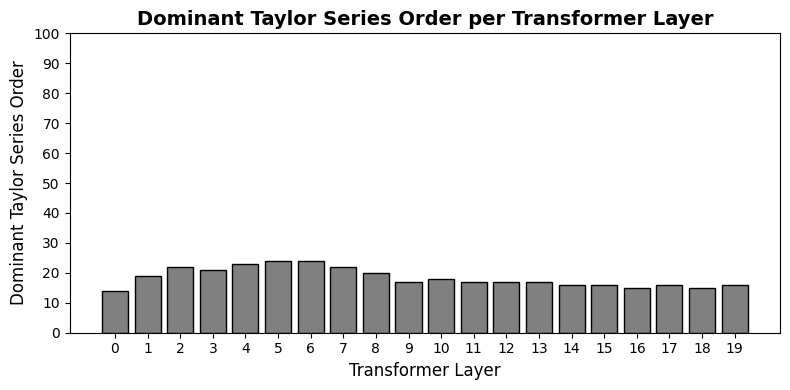

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data_ = per_layer_vals

# Sample plot using provided values
fig, ax = plt.subplots(figsize=(8, 4))

# Main bar plot
ax.bar(
    np.arange(0, data_.shape[0]),
    data_.transpose(-1, -2).argmax(0),
    color='gray',
    edgecolor='black'
)

# Aesthetics and labels
ax.set_title("Dominant Taylor Series Order per Transformer Layer", fontsize=14, fontweight='bold')
ax.set_xlabel("Transformer Layer", fontsize=12)
ax.set_ylabel("Dominant Taylor Series Order", fontsize=12)

# Improve ticks
ax.set_xticks(np.arange(0, data_.shape[0], step=1))
ax.set_yticks(np.arange(0, data_.shape[-1] + 1, step=10))
ax.tick_params(axis='both', which='major', labelsize=10)

# Tight layout for clean spacing
plt.tight_layout()
plt.show()

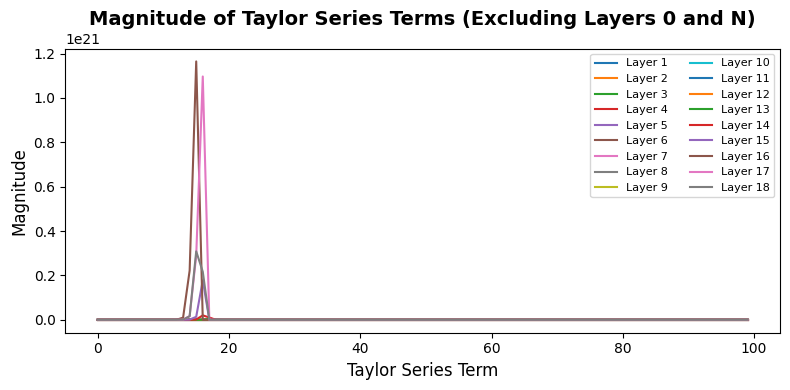

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
fig, ax = plt.subplots(figsize=(8, 4))

# Exclude first and last layer
data = per_layer_vals.transpose(-1, -2)[:, 1:-1].transpose(-1, -2)

# Plot each layer
ax.plot(data.T, linewidth=1.5)

# Title and axis labels
ax.set_title("Magnitude of Taylor Series Terms (Excluding Layers 0 and N)", fontsize=14, fontweight='bold')
ax.set_xlabel("Taylor Series Term", fontsize=12)
ax.set_ylabel("Magnitude", fontsize=12)

# Legend (layers 1 to N-2)
ax.legend([f"Layer {i}" for i in range(1, per_layer_vals.shape[0]-1)], fontsize=8, ncol=2, loc='upper right')

# Format ticks
ax.tick_params(axis='both', which='major', labelsize=10)

# Tight layout and save
plt.tight_layout()
plt.show()


/tmp/ipykernel_747164/898440890.py:4: RuntimeWarning: divide by zero encountered in log
  log_data = np.log(per_layer_vals).transpose(-1, -2)


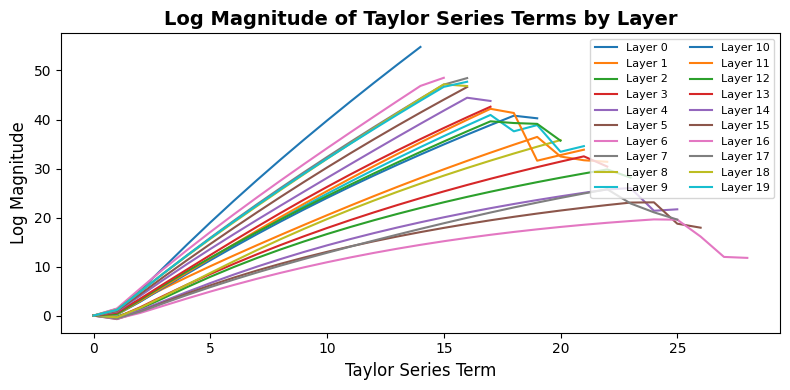

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

# Compute and plot log magnitude
log_data = np.log(per_layer_vals).transpose(-1, -2)
ax.plot(log_data, linewidth=1.5)

# Title and axis labels
ax.set_title("Log Magnitude of Taylor Series Terms by Layer", fontsize=14, fontweight='bold')
ax.set_xlabel("Taylor Series Term", fontsize=12)
ax.set_ylabel("Log Magnitude", fontsize=12)

# Legend (all layers)
ax.legend([f"Layer {i}" for i in range(per_layer_vals.shape[0])], fontsize=8, ncol=2, loc='upper right')

# Format ticks
ax.tick_params(axis='both', which='major', labelsize=10)

# Tight layout and save
plt.tight_layout()
plt.show()
